## Tratamento Navios Tanque Completo

### Tratamentos Iniciais

In [287]:
import pm4py
import pandas as pd
from unidecode import unidecode
import string
import datetime
import numpy as np

In [288]:
# - Bases: ‘Relatório_NT_2023.xlsx’ e Relatório_NT_2022.xlsx’
# - Concatenar as duas bases

navioTanque1 = pd.read_excel("Arquivos\\Relatorio_NT_2022.xlsx")
navioTanque2 = pd.read_excel("Arquivos\\Relatorio_NT_2023.xlsx")

# Concatena os DataFrames
df_concatenado = pd.concat([navioTanque1, navioTanque2], ignore_index=True)

# Escreve o DataFrame concatenado em um novo arquivo Excel
df_concatenado.to_excel("Arquivos\\navios_concatenado.xlsx", index=False)
len(df_concatenado)

3285

Remover acentos e substituir caracteres especiais

In [289]:
df_concatenado = df_concatenado.map(lambda x: unidecode(str(x)) if isinstance(x, str) else x)

Padronizar formato de data e hora

In [290]:
lFormatDate = ['Data Prevista de Chegada', 'Data Prevista de Saída', 
'H.O.C.', 'Amarração','Início de Bombeio', 'Fim de Bombeio', 'Desamarração', 'H.O.S.', 'Início Primeira Amarração','Fim Primeira Amarração','Início Primeira Conexão','Fim Primeira Conexão',
'Início Primeiro Bombeio','Fim Último Bombeio','Início Última Desconexão','Fim Última Desconexão','Início Última Desamarração','Fim Última Desamarração']

for coluna in lFormatDate:
    df_concatenado[coluna] = pd.to_datetime(df_concatenado[coluna], dayfirst=True)

print(len(df_concatenado))

3285


Remover colunas que não são importantes

In [291]:
df_concatenado.drop(columns=["Classe do Navio","Rebocador","Hora Top","Alívio Crítico","Apuração Alívio Crítico","Volume Acumulado Perdas","Lifter"], inplace=True)

Drop duplicates

In [292]:
df_concatenado = df_concatenado.drop_duplicates()

In [293]:
len(df_concatenado)

3226

Criando a coluna ID

In [294]:
df_concatenado.loc[:,'ID'] = range(0, len(df_concatenado))
columns = ['ID'] + [colunas for colunas in df_concatenado.columns if colunas != 'ID']
df_concatenado = df_concatenado[columns]

cria coluna uep e trocar "PETROBRAS" por "p-"

In [295]:
# Criar a nova coluna "UEP" com valores vazios inicialmente
df_concatenado.insert(2, "UEP", "")

# Atualizar a coluna "UEP" com a substituição
df_concatenado["UEP"] = df_concatenado["Instalação Naval"].str.replace("PETROBRAS", "P-")

In [296]:
# Percebemos durante nossas análises que temos H.O.C repetidos e muito distantes da Amarração - isso ocorre devido a erros de preenchimento (repetiram o mesmo HOC pra viagens difernetes de um mesmo navio e plataforma)
# Então iremos considerar H.O.C = Data Prevista de Chegada quando o Tempo_entre_previsto_chegada >= 48horas (2 dias)

#Criando uma lista vazia
HOC = []
#Percorrendo a base
for (idx, val) in df_concatenado.iterrows():
    #Quando o tempo entre a chegada e amarração for maior do que 48h para a linha em questão
    series = (val['Início Primeira Amarração'] - val['H.O.C.']).total_seconds() / (60 * 60)
    if series>=48:
        #Adiciona à lista criada o valor da data prevista de chegada da linha em questão
        HOC.append(val['Data Prevista de Chegada'])
    #Caso contrário
    else:
        #Adiciona à lista criada o próprio valor de H.O.C. da linha em questão
        HOC.append(val['H.O.C.'])
#Após percorrer toda a base adicione a lista criada com seus respectivos valores na coluna H.O.C. da base na ordem em que ela está
df_concatenado['H.O.C.'] = HOC

#Logo, teremos na coluna H.O.C. da base H.O.C = Data Prevista de Chegada quando o Tempo_entre_previsto_chegada >= 48horas (2 dias), e caso contrário teremos o valor original do H.O.C para aquele registro

 Retirando o espaço antes e no final dos nomes nas colunas UEP e Navio

In [297]:
df_concatenado.loc[:,"UEP"] = df_concatenado.loc[:,"UEP"].str.strip()
df_concatenado.loc[:,"Navio"] = df_concatenado.loc[:,"Navio"].str.strip()

Tirar duplicatas dos casos que possuem mesmo HOC, Instalação Naval e Navio

In [298]:
df_concatenado = df_concatenado.sort_values(by=['H.O.C.'])
df_concatenado = df_concatenado.drop_duplicates(subset=['Navio', 'Instalação Naval', 'H.O.C.'])
len(df_concatenado)

3221

Criando colunas TNP

In [299]:
df_concatenado.reset_index()
for indice, linha in df_concatenado.iterrows():
    df_concatenado.at[indice, 'TNP_Amarracao_Conexao'] = (linha['Início Primeira Conexão'] - linha['Fim Primeira Amarração']).total_seconds() / (60 * 60)
    df_concatenado.at[indice, 'TNP_Bombeio_Desconexao'] = (linha['Início Última Desconexão'] - linha['Fim Último Bombeio']).total_seconds() / (60 * 60)
    df_concatenado.at[indice, 'TNP_H.O.C_Amarracao'] = (linha['Início Primeira Amarração'] - linha['H.O.C.']).total_seconds() / (60 * 60)
    df_concatenado.at[indice, 'TNP_Conexao_Bombeio'] = (linha['Início Primeiro Bombeio'] - linha['Fim Primeira Conexão']).total_seconds() / (60 * 60)
    df_concatenado.at[indice, 'TNP_Desamarracao_HOS'] = (linha['H.O.S.'] - linha['Fim Última Desamarração']).total_seconds() / (60 * 60)
    df_concatenado.at[indice, 'TNP_Desconexao_Desamarracao'] = (linha['Início Última Desamarração'] - linha['Fim Última Desconexão']).total_seconds() / (60 * 60)

df_concatenado

,ID,Unidade Operativa,UEP,Instalação Naval,Navio,Volume Programado,Data Prevista de Chegada,Data Prevista de Saída,Viagem,Destino,...,Temperatura (°C),Densidade 20°,Volume de Água Livre (m³),Responsável,TNP_Amarracao_Conexao,TNP_Bombeio_Desconexao,TNP_H.O.C_Amarracao,TNP_Conexao_Bombeio,TNP_Desamarracao_HOS,TNP_Desconexao_Desamarracao
8,7,LIBRA,FPSO Pioneiro de Libra,FPSO Pioneiro de Libra,TUVA KNUTSEN,73390,2022-01-01 00:01:00,2022-01-02 05:12:00,FPL TT 015,CARGA TOTAL,...,"33,8","0,8746",Valor Medido,URVI,0.300000,2.400000,3.383333,2.133333,0.200000,0.200000
6,5,BUZIOS,P- 77,PETROBRAS 77,BRASIL 2014,67000,2022-01-01 05:00:00,2022-01-01 23:30:00,319 TA,ANGRA DOS REIS,...,"45,55","0,8803",0,FM47,0.016667,0.900000,4.200000,1.700000,0.300000,0.700000
7,6,UN-BS,FPSO Cidade de Mangaratiba MV24,FPSO Cidade de Mangaratiba MV24,LAMBADA SPIRIT,79000,2022-01-01 06:00:00,2022-01-02 04:00:00,SH084,CARGA SHELL,...,"36,22","0,8578",Valor Medido,LN8U,0.050000,2.166667,2.966667,1.500000,0.250000,0.033333
9,8,UN-BS,FPSO Cidade de Marica,FPSO Cidade de Marica,EAGLE PAULINIA,75000,2022-01-01 10:00:00,2022-01-02 07:00:00,072 TA,T.B.N.,...,"50,8","0,8734",Valor Medido,YU2W,0.250000,1.066667,3.166667,2.750000,0.166667,0.200000
10,9,UN-BS,FPSO Cidade de Itaguai MV26,FPSO Cidade de Itaguai MV26,EAGLE PARANA,115000,2022-01-01 12:00:00,2022-01-02 12:25:00,377 TA,T.B.N.,...,"38,97","0,8601",Valor Medido,YU2W,0.083333,1.116667,4.083333,1.333333,0.416667,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3281,3222,UN-ES,FSO Cidade de Macae - MV15,FSO Cidade de Macae - MV15,EAGLE CAMBE,151000,2023-07-31 03:01:00,2023-08-01 15:23:45,055 TA,T.B.N.,...,"22,3","0,8815",Valor Medido,TES1,0.200000,2.383333,3.533333,1.333333,0.333333,0.216667
3277,3218,UN-BC,FPSO Campos dos Goytacases MV29,FPSO Campos dos Goytacases MV29,RECIFE KNUTSEN,80000,2023-07-31 01:00:00,2023-07-31 22:20:00,487 TA,ILHA DAGUA,...,"38,62","0,8917",Valor Medido,KMT4,0.100000,1.500000,4.600000,1.483333,0.383333,0.300000
3283,3224,UN-BS,FPSO Cidade de Marica,FPSO Cidade de Marica,EAGLE PAULINIA,155000,2023-07-31 08:00:00,2023-08-01 16:55:00,155 TA,T.B.N.,...,"50,23","0,8711",NaN,TVX3,0.166667,0.833333,3.416667,2.000000,0.116667,0.283333
3284,3225,UN-BUZ,P- 76,PETROBRAS 76,ELKA LEBLON,80000,2023-07-31 13:00:00,2023-08-01 18:00:00,402 TA,T.B.N.,...,"41,23","0,8762",NaN,ZPDI,0.050000,2.100000,3.716667,1.300000,1.800000,0.016667


In [300]:
# ANÁLISE POR TNP
df_concatenado[['TNP_H.O.C_Amarracao','TNP_Amarracao_Conexao','TNP_Conexao_Bombeio','TNP_Bombeio_Desconexao','TNP_Desconexao_Desamarracao',
             "TNP_Desamarracao_HOS"]].describe().round(2)

,TNP_H.O.C_Amarracao,TNP_Amarracao_Conexao,TNP_Conexao_Bombeio,TNP_Bombeio_Desconexao,TNP_Desconexao_Desamarracao,TNP_Desamarracao_HOS
count,3221.00,3221.00,3221.00,3221.00,3221.00,3221.00
mean,9.22,0.43,2.46,1.88,0.24,0.80
std,11.13,1.87,3.66,2.06,0.44,3.16
min,-26.83,-0.02,0.02,-5.12,0.02,0.02
25%,3.47,0.07,1.60,1.20,0.03,0.25
50%,4.98,0.20,1.97,1.52,0.17,0.33
75%,10.30,0.33,2.53,2.00,0.30,0.50
max,154.42,45.35,159.07,54.50,17.50,120.25


In [301]:
df_concatenado['TNP_H.O.C_Amarracao'].sum()

29702.533333333333

Removendo colunas com valores negativos

In [302]:
remover = df_concatenado.loc[(df_concatenado['TNP_Amarracao_Conexao'] < 0) |
                (df_concatenado['TNP_Bombeio_Desconexao'] < 0) |
                (df_concatenado['TNP_H.O.C_Amarracao'] < 0) |
                (df_concatenado['TNP_Conexao_Bombeio'] < 0) |
                (df_concatenado['TNP_Desconexao_Desamarracao'] < 0) |
                (df_concatenado['TNP_Desamarracao_HOS'] < 0)].index
# Remove as linhas com os índices identificados
df_concatenado = df_concatenado.drop(remover)
# Se desejar redefinir o índice após a remoção das linhas
df_concatenado = df_concatenado.reset_index(drop=True)
len(df_concatenado)

3213

## ALTERANDO O FORMATO DA BASE

In [303]:
# Selecionar apenas as colunas necessárias para alteração no formato do dataframe
nt_colunas = ['ID', 'H.O.C.', 'Início Primeira Amarração', 'Fim Primeira Amarração', 'Início Primeira Conexão', 'Fim Primeira Conexão', 'Início Primeiro Bombeio','Fim Último Bombeio', 'Início Última Desconexão', 'Fim Última Desconexão','Início Última Desamarração', 'Fim Última Desamarração', 'H.O.S.']
# Selecionar e definir as colunas que serão alteradas
colunas_alteradas = ['H.O.C.', 'Início Primeira Amarração', 'Fim Primeira Amarração','Início Primeira Conexão', 'Fim Primeira Conexão', 'Início Primeiro Bombeio','Fim Último Bombeio', 'Início Última Desconexão', 'Fim Última Desconexão','Início Última Desconexão', 'Fim Última Desconexão', 'Início Última Desamarração','Fim Última Desamarração', 'H.O.S.']
# Usar o método melt para transformar as colunas em registros
df_transformado = pd.melt(df_concatenado[nt_colunas], id_vars=['ID'], value_vars=colunas_alteradas, var_name='Ocorrência', value_name='Data')
# Selecionar apenas as colunas necessárias para a junção
colunas_restauradas = ['ID', 'Unidade Operativa', 'UEP', 'Navio', 'Volume Programado','Volume Retirado', 'Viagem', 'Destino', 'Data Prevista de Chegada','Data Prevista de Saída']
# Realizar a junção dos DataFrames usando a coluna 'ID' como chave
df_final = pd.merge(df_concatenado[colunas_restauradas], df_transformado, on='ID', how='right')

Ordenar o DataFrame final por 'ID' e 'Data'

In [304]:
#Ordenando a base da forma correta - por ID e data
df_final['Data'] = pd.to_datetime(df_final['Data'], format='%d/%m/%Y %H:%M:%S')
df_final = df_final.sort_values(by=['ID','Data'])

Adicionar as colunas 'Início' e 'Término' com base nas datas da ocorrência e da próxima ocorrência para o mesmo ID

In [305]:
#Criando colunas de início e fim com todos os registros em branco
df_final['Início']=''
df_final['Término']=''

#Adicionando os respectivos valores às colunas de início e término - início e fim de cada ocorrência- pois agora temos uma ocorrência em cada linha
#Percorrendo a base
for i, row in df_final.iterrows():
    if i < len(df_final) - 1:
        #Definindo linha atual e linha seguinte
        linha_atual = df_final.iloc[i]
        linha_seguinte = df_final.iloc[i+1]
        #Se a linha atual e a linha seguinte forem referentes ao mesmo ID
        if (linha_atual["ID"] == linha_seguinte["ID"]): 
            #A data da linha atual é na verdade o início da ocorrência descrita na linha atual
            df_final.at[linha_atual.name, 'Início'] = linha_atual["Data"]
            #E a data da linha seguinte é na verdade o término da ocorrência descrita na linha atual
            df_final.at[linha_atual.name, 'Término'] = linha_seguinte["Data"]
        #Caso as linhas não tenham mesmo ID apenas adicionamos o início da ocorrência da linha atual como a data na linha atual
        df_final.at[linha_atual.name, 'Início'] = linha_atual["Data"]
df_final.to_excel('c:\\Users\\caiobarreto\\Downloads\\Relatório_NT_Concatenado.xlsx')
len(df_final)

38556

Excluir as colunas com “Ocorrência” = ”Fim”

In [306]:
# Filtrar as linhas em que a "Ocorrência" contém a palavra "Fim" e obter seus índices
indices_para_remover = df_final[df_final['Ocorrência'].str.contains('Fim')].index
# Remover as linhas correspondentes aos índices obtidos
df_final.drop(indices_para_remover, inplace=True)
len(df_final)

22491

Renomear as colunas 

In [307]:
# Retirar a palavra Início da ocorrência
df_final['Ocorrência'] = df_final['Ocorrência'].str.replace('Início ', '')
df_final['Ocorrência'] = df_final['Ocorrência'].str.replace('Última ', '')
df_final['Ocorrência'] = df_final['Ocorrência'].str.replace('Primeiro ', '')
df_final['Ocorrência'] = df_final['Ocorrência'].str.replace('Primeira ', '')

Remover a coluna ‘Data’

In [308]:
# Removendo as colunas, inplace é pra não precisar reatribuir e axis 1 serve pra dizer que se trata de uma coluna
df_final.drop(['Data'],inplace=True, axis=1)

In [309]:
df_final.to_excel('c:\\Users\\caiobarreto\\Downloads\\BaseFinalNT.xlsx')

In [310]:
df_final.describe().round(2)

,ID,Volume Programado,Volume Retirado,Data Prevista de Chegada,Data Prevista de Saída
count,22491.00,22491.00,22491.00,22491,22491
mean,1610.22,80744.94,80277.89,2022-10-16 02:43:58.209150208,2022-10-17 12:54:49.128540416
min,0.00,2000.00,1990.10,2022-01-01 00:01:00,2022-01-01 23:30:00
25%,804.00,70000.00,70090.00,2022-05-23 12:01:00,2022-05-25 09:15:00
50%,1608.00,79400.00,78946.00,2022-10-13 14:22:00,2022-10-15 02:54:00
75%,2416.00,86000.00,85689.25,2023-03-08 13:00:00,2023-03-09 23:39:34
max,3225.00,166000.00,170507.00,2023-07-31 13:00:00,2023-08-01 18:00:00
std,931.12,30100.69,30300.07,NaN,NaN


## BASE INTERRUPÇÕES

In [311]:
dfInt = pd.read_excel("Arquivos\\eventos_operacoes_interrupcoes2.xlsx")

Filtrar apenas para quem teve interrupção 

In [312]:
# Filtrar apenas as linhas em que 'Duração Interrupção' é maior que zero e reatribuir ao DataFrame dfInt
dfInt = dfInt[dfInt['Duração Interrupção'] > 0]

Retirar acento e ç

In [313]:
dfInt = dfInt.apply(lambda x: x.map(lambda y: unidecode(str(y)) if isinstance(y, str) else y))

Criar a coluna UEP na posição 2 

In [314]:
# Adicionando a coluna UEP 
dfInt.insert(2, 'UEP', dfInt['INNA_SG_INSTALACAO_NAVAL'].str.replace('PETROBRAS', 'P-', regex=True))

Alterar os nomes das categorias

In [315]:
# Faz um dicionário com os nomes a serem mudados na UEP
trocaNomes = {
    'FPBAR': 'FPSO Almirante Barroso',
    'FPCGZ': 'FPSO Campos dos Goytacases MV29',
    'CAPX': 'FPSO Capixaba',
    'FPCRC': 'FPSO CARIOCA MV30',
    'FPNIT': 'FPSO Cid. Niteroi MV18',
    'CDAN': 'FPSO Cidade de Anchieta',
    'FPCAR': 'FPSO Cidade de Angra Reis MV22',
    'FPCIB': 'FPSO Cidade de Ilhabela',
    'FPCMB': 'FPSO Cidade de Mangaratiba MV24',
    'FPCIG': 'FPSO Cidade de Itaguai MV26',
    'FPCMC': 'FPSO Cidade de Marica',
    'FPCPY': 'FPSO Cidade de Paraty',
    'FPCST': 'FPSO Cidade de Santos MV20',
    'FPCSQ': 'FPSO Cidade de Saquarema',
    'FPCSP': 'FPSO Cidade Sao Paulo MV23',
    'FPGNB': 'FPSO Guanabara - MV31',
    'FPPLB': 'FPSO Pioneiro de Libra',
    'FSME': 'FSO Cidade de Macae - MV15'
}

# Faz a troca dos nomes da UEP utilizando o replace
dfInt['UEP'] = dfInt['UEP'].replace(trocaNomes)

Renomear as colunas para ficar com a mesma nomenclatura que a base NT 

In [316]:
# Definindo o dicionário para renomear as colunas
nomeColunas = {
    'OPOF_CD_VIAGEM': 'Viagem',
    'OPOF_NM_NAVIO': 'Navio',
    'OPOF_NM_DESTINO': 'Destino',
    'EOOF_IN_TIPO': 'TIPO_INTERRUPCAO',
    'Duração Interrupção': 'DURACAO_INTERRUPCAO',
    'EOOF_DT_REALIZADA': 'INICIO_INTERRUPCAO',
    'EOOF_DT_FIM': 'FIM_INTERRUPCAO',
    'OPOF_DT_ENTRADA_PREVISTA': 'Data Prevista de Chegada',
    'OPOF_DT_SAIDA_PREVISTA': 'Data Prevista de Saída'
}

# Renomeando as colunas conforme o dicionário 
dfInt.rename(columns=nomeColunas, inplace=True)

Retirar o espaço do final dos nomes 

In [317]:
# Remover espaços em branco antes e depois dos nomes nas colunas UEP e Navio
dfInt['UEP'] = dfInt['UEP'].str.strip()
dfInt['Navio'] = dfInt['Navio'].str.strip()

 Selecionar apenas as colunas que interessam

In [318]:
# Selecionar apenas as colunas necessárias do DataFrame dfInt
colunasSel = dfInt[['UEP', 'Viagem', 'Navio', 'Destino', 'TIPO_INTERRUPCAO', 'DURACAO_INTERRUPCAO', 'INICIO_INTERRUPCAO', 'FIM_INTERRUPCAO', 'Data Prevista de Chegada', 'Data Prevista de Saída']]
colunasSel.describe()

,DURACAO_INTERRUPCAO,INICIO_INTERRUPCAO,FIM_INTERRUPCAO,Data Prevista de Chegada,Data Prevista de Saída
count,414.000000,414,414,414,414
mean,4.809219,2022-10-06 14:55:30.869565184,2022-10-06 19:44:04.057970688,2022-10-05 15:21:19.855072512,2022-10-07 13:50:13.644927744
min,0.016667,2022-01-01 00:00:00,2022-01-01 00:24:00,2021-12-31 04:00:00,2022-01-01 19:29:05
25%,0.500000,2022-05-17 00:27:15,2022-05-17 13:22:30,2022-05-16 00:22:30,2022-05-18 07:17:32.249999872
50%,1.325000,2022-10-01 09:31:00,2022-10-01 12:26:00,2022-09-30 09:30:00,2022-10-01 22:04:15
75%,4.575000,2023-02-21 13:03:00,2023-02-21 16:34:30,2023-02-20 12:00:00,2023-02-22 12:03:48
max,92.566667,2023-07-27 00:56:00,2023-07-27 01:30:00,2023-07-26 12:00:00,2023-07-27 14:03:41
std,10.047754,NaN,NaN,NaN,NaN


In [319]:
df_final.describe()

,ID,Volume Programado,Volume Retirado,Data Prevista de Chegada,Data Prevista de Saída
count,22491.000000,22491.000000,22491.000000,22491,22491
mean,1610.219421,80744.940554,80277.892009,2022-10-16 02:43:58.209150208,2022-10-17 12:54:49.128540416
min,0.000000,2000.000000,1990.100000,2022-01-01 00:01:00,2022-01-01 23:30:00
25%,804.000000,70000.000000,70090.000000,2022-05-23 12:01:00,2022-05-25 09:15:00
50%,1608.000000,79400.000000,78946.000000,2022-10-13 14:22:00,2022-10-15 02:54:00
75%,2416.000000,86000.000000,85689.250000,2023-03-08 13:00:00,2023-03-09 23:39:34
max,3225.000000,166000.000000,170507.000000,2023-07-31 13:00:00,2023-08-01 18:00:00
std,931.123604,30100.692333,30300.068265,NaN,NaN


In [320]:
dfInt.to_excel('Arquivos\\baseInterrupcoes_AntesDoMerge.xlsx')

INCLUSÃO DA INTERRUPÇÃO NA BASE NOVA NT

In [321]:
# Junção das bases de interrupções e NT
dfUni = pd.merge(df_final, colunasSel, on=['UEP', 'Viagem', 'Navio', 'Destino', 'Data Prevista de Chegada', 'Data Prevista de Saída'], how='left')
len(dfUni)

22610

Restringir as características de interrupção apenas aos bombeios

In [322]:
 # Substituir valor da coluna 'TIPO_INTERRUPCAO' por 'Interrupção Bombeio' onde 'Ocorrência' contém 'Bombeio' e 'TIPO_INTERRUPCAO' = 'B005', caso contrário, substituir por ''
condicao_1 = (dfUni['Ocorrência'].str.contains('Bombeio')) & (dfUni['TIPO_INTERRUPCAO'] == 'B005')
dfUni.loc[condicao_1, 'TIPO_INTERRUPCAO'] = 'Interrupção Bombeio'
dfUni.loc[~condicao_1, 'TIPO_INTERRUPCAO'] = ''

# Manter valor da coluna 'DURACAO_INTERRUPCAO' onde 'Ocorrência' contém 'Bombeio' e 'DURACAO_INTERRUPCAO' > 0
condicao_2 = (dfUni['Ocorrência'].str.contains('Bombeio')) & (dfUni['DURACAO_INTERRUPCAO'] > 0)
dfUni.loc[condicao_2, 'DURACAO_INTERRUPCAO'] = dfUni.loc[condicao_2, 'DURACAO_INTERRUPCAO']
dfUni.loc[~condicao_2, 'TIPO_INTERRUPCAO'] = ''

# Manter valor da coluna 'INICIO_INTERRUPCAO' onde 'Ocorrência' contém 'Bombeio' e 'TIPO_INTERRUPCAO' = 'Interrupção Bombeio'
condicao_3 = (dfUni['Ocorrência'].str.contains('Bombeio')) & (dfUni['TIPO_INTERRUPCAO'] == 'Interrupção Bombeio')
dfUni.loc[condicao_3, 'INICIO_INTERRUPCAO'] = dfUni.loc[condicao_3, 'INICIO_INTERRUPCAO']
dfUni.loc[~condicao_3, 'TIPO_INTERRUPCAO'] = ''

# Manter valor da coluna 'FIM_INTERRUPCAO' onde 'Ocorrência' contém 'Bombeio' e 'TIPO_INTERRUPCAO' = 'Interrupção Bombeio'
condicao_4 = (dfUni['Ocorrência'].str.contains('Bombeio')) & (dfUni['TIPO_INTERRUPCAO'] == 'Interrupção Bombeio')
dfUni.loc[condicao_4, 'FIM_INTERRUPCAO'] = dfUni.loc[condicao_4, 'FIM_INTERRUPCAO']
dfUni.loc[~condicao_4, 'TIPO_INTERRUPCAO'] = ''

In [323]:
dfUni.describe()

,ID,Volume Programado,Volume Retirado,Data Prevista de Chegada,Data Prevista de Saída,DURACAO_INTERRUPCAO,INICIO_INTERRUPCAO,FIM_INTERRUPCAO
count,22610.000000,22610.000000,22610.000000,22610,22610,1162.000000,1162,1162
mean,1613.075232,80800.524458,80323.978608,2022-10-16 14:57:38.881114368,2022-10-18 01:08:58.033436672,3.915863,2022-09-28 23:46:35.783132672,2022-09-29 03:41:32.891566336
min,0.000000,2000.000000,1990.100000,2022-01-01 00:01:00,2022-01-01 23:30:00,0.016667,2022-01-05 22:50:00,2022-01-06 00:00:00
25%,807.000000,70000.000000,70090.000000,2022-05-24 06:00:00,2022-05-25 19:00:00,0.366667,2022-04-26 03:18:00,2022-04-26 12:18:00
50%,1610.500000,79500.000000,78959.955000,2022-10-14 06:00:00,2022-10-15 16:44:33,0.900000,2022-10-01 15:25:00,2022-10-01 15:41:00
75%,2420.000000,87000.000000,86001.940000,2023-03-09 13:00:00,2023-03-10 20:30:00,2.200000,2023-02-19 02:11:00,2023-02-20 02:10:00
max,3225.000000,166000.000000,170507.000000,2023-07-31 13:00:00,2023-08-01 18:00:00,92.566667,2023-07-27 00:56:00,2023-07-27 01:30:00
std,930.937902,30104.685143,30301.415032,NaN,NaN,10.781362,NaN,NaN


Duplicar as linhas em que acontece as interrupções 

In [324]:
indices_para_remover = []
# da ruim
# df_filtered = dfUni[dfUni['TIPO_INTERRUPCAO'].notna()]
# df_resultado = pd.concat([dfUni, df_filtered], ignore_index=True)
for i, row in dfUni.iterrows():
    if i < len(dfUni) - 2:
        linha_atual = dfUni.iloc[i]
        linha_seguinte = dfUni.iloc[i+1]
        linha_seguinte_seguinte = dfUni.iloc[i+2]
        if ((linha_atual["ID"] == linha_seguinte["ID"]) & (linha_atual['TIPO_INTERRUPCAO'] == 'Interrupção Bombeio') & (linha_seguinte['TIPO_INTERRUPCAO'] == 'Interrupção Bombeio') & (linha_atual['DURACAO_INTERRUPCAO'] != linha_seguinte['DURACAO_INTERRUPCAO'])):
             indices_para_remover.append(i+2)
df_resultado = dfUni.drop(indices_para_remover)
df_resultado

,ID,Unidade Operativa,UEP,Navio,Volume Programado,Volume Retirado,Viagem,Destino,Data Prevista de Chegada,Data Prevista de Saída,Ocorrência,Início,Término,TIPO_INTERRUPCAO,DURACAO_INTERRUPCAO,INICIO_INTERRUPCAO,FIM_INTERRUPCAO
0,0,UN-BS,P- 67,FORTALEZA KNUTSEN,80000,81382.81,423 TA,T.B.N.,2022-04-27 12:00:00,2022-04-28 09:30:00,H.O.C.,2022-04-27 03:00:00,2022-04-27 09:04:00,,NaN,NaT,NaT
1,0,UN-BS,P- 67,FORTALEZA KNUTSEN,80000,81382.81,423 TA,T.B.N.,2022-04-27 12:00:00,2022-04-28 09:30:00,Amarração,2022-04-27 09:04:00,2022-04-27 09:35:00,,NaN,NaT,NaT
2,0,UN-BS,P- 67,FORTALEZA KNUTSEN,80000,81382.81,423 TA,T.B.N.,2022-04-27 12:00:00,2022-04-28 09:30:00,Conexão,2022-04-27 09:40:00,2022-04-27 10:11:00,,NaN,NaT,NaT
3,0,UN-BS,P- 67,FORTALEZA KNUTSEN,80000,81382.81,423 TA,T.B.N.,2022-04-27 12:00:00,2022-04-28 09:30:00,Bombeio,2022-04-27 12:00:00,2022-04-28 07:00:00,,NaN,NaT,NaT
4,0,UN-BS,P- 67,FORTALEZA KNUTSEN,80000,81382.81,423 TA,T.B.N.,2022-04-27 12:00:00,2022-04-28 09:30:00,Desconexão,2022-04-28 08:30:00,2022-04-28 08:55:00,,NaN,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22605,3225,UN-BUZ,P- 76,ELKA LEBLON,80000,81372.15,402 TA,T.B.N.,2023-07-31 13:00:00,2023-08-01 18:00:00,Conexão,2023-07-31 16:30:00,2023-07-31 17:48:00,,NaN,NaT,NaT
22606,3225,UN-BUZ,P- 76,ELKA LEBLON,80000,81372.15,402 TA,T.B.N.,2023-07-31 13:00:00,2023-08-01 18:00:00,Bombeio,2023-07-31 19:06:00,2023-08-01 12:42:00,,NaN,NaT,NaT
22607,3225,UN-BUZ,P- 76,ELKA LEBLON,80000,81372.15,402 TA,T.B.N.,2023-07-31 13:00:00,2023-08-01 18:00:00,Desconexão,2023-08-01 14:48:00,2023-08-01 15:36:00,,NaN,NaT,NaT
22608,3225,UN-BUZ,P- 76,ELKA LEBLON,80000,81372.15,402 TA,T.B.N.,2023-07-31 13:00:00,2023-08-01 18:00:00,Desamarração,2023-08-01 15:37:00,2023-08-01 16:12:00,,NaN,NaT,NaT


Ordenar por ID e Início 

In [325]:
# Ordenar por ID e início
df_resultado.sort_values(by=['ID', 'Início','INICIO_INTERRUPCAO'], inplace=True)

Percebemos que em alguns casos (Ex: ID 394) o início da interrupção acontece antes do início do bombeio. Nesses casos, substituir valor de início da interrupção pelo valor de início do bombeio (‘Início’). O mesmo acontece para as datas de fim, se o fim da interrupção for depois do fim do bombeio, substituir fim da interrupção com o valor de fim do bombeio

In [326]:

# Verificar se TIPO_INTERRUPCAO está vazio e substituir os valores das outras colunas
condicao = df_resultado['TIPO_INTERRUPCAO'] == ''
df_resultado.loc[condicao, ['DURACAO_INTERRUPCAO', 'INICIO_INTERRUPCAO', 'FIM_INTERRUPCAO']] = np.nan

# Substituir o início da interrupção pelo valor de início do bombeio onde necessário
df_resultado.loc[df_resultado['INICIO_INTERRUPCAO'] < df_resultado['Início'], 'INICIO_INTERRUPCAO'] = df_resultado['Início']

# Substituir o fim da interrupção pelo valor de fim do bombeio onde necessário
df_resultado.loc[df_resultado['FIM_INTERRUPCAO'] > df_resultado['Término'], 'FIM_INTERRUPCAO'] = df_resultado['Término']

Alterar as datas de Término da primeira interrupção e Início da segunda interrupção dentro de um mesmo ID

In [327]:
# Verificar se TIPO_INTERRUPCAO de linhas consecutivas são iguais a "Interrupção Bombeio"
condicao_1 = (df_resultado['TIPO_INTERRUPCAO'].shift() == 'Interrupção Bombeio') & (df_resultado['TIPO_INTERRUPCAO'] == 'Interrupção Bombeio')
# Verificar se DURACAO_INTERRUPCAO de linhas consecutivas são diferentes
condicao_2 = (df_resultado['TIPO_INTERRUPCAO'].shift() == 'Interrupção Bombeio') & (df_resultado['TIPO_INTERRUPCAO'] == 'Interrupção Bombeio') & (df_resultado['DURACAO_INTERRUPCAO'].shift() != df_resultado['DURACAO_INTERRUPCAO'])
# Atualizar as datas conforme as condições especificadas
df_resultado.loc[condicao_1, 'Término'] = df_resultado['INICIO_INTERRUPCAO'].shift(-1)
df_resultado.loc[condicao_1, 'Início'] = df_resultado['FIM_INTERRUPCAO']
df_resultado.loc[condicao_2, 'Início'] = df_resultado['FIM_INTERRUPCAO']

Retirar os casos com bombeio instantâneo

In [328]:
for indice,linha in df_resultado.iterrows():
    if linha['Início'] == linha['Término']:
       df_resultado.drop(index=indice)

Para a ocorrência H.O.S. trocar os términos que estão vazios pelos inícios, pois o H.O.S. é sempre instantâneo.


In [329]:
for index,linha in df_resultado.iterrows():
    if linha['Ocorrência'] == "H.O.S.":
        if type(df_resultado.loc[index,'Término']) == pd._libs.tslibs.nattype.NaTType:
            df_resultado.loc[index,'Término'] = df_resultado.loc[index,"Início"]
df_resultado.to_excel('Arquivos\\base_final.xlsx')

In [330]:
#Base final
df_resultado.describe().round(2)

,ID,Volume Programado,Volume Retirado,Data Prevista de Chegada,Data Prevista de Saída,DURACAO_INTERRUPCAO,INICIO_INTERRUPCAO,FIM_INTERRUPCAO
count,22593.00,22593.00,22593.00,22593,22593,163.00,163,163
mean,1612.67,80792.62,80317.42,2022-10-16 13:13:18.604965888,2022-10-17 23:24:33.742221056,3.97,2022-09-27 15:39:00.368098304,2022-09-27 19:33:52.638036992
min,0.00,2000.00,1990.10,2022-01-01 00:01:00,2022-01-01 23:30:00,0.02,2022-01-05 22:50:00,2022-01-06 00:00:00
25%,807.00,70000.00,70090.00,2022-05-24 06:00:00,2022-05-25 19:00:00,0.37,2022-04-24 15:06:00,2022-04-24 19:48:00
50%,1610.00,79500.00,78952.91,2022-10-14 00:00:00,2022-10-15 09:34:00,0.92,2022-09-29 00:26:00,2022-09-29 00:45:00
75%,2419.00,87000.00,85969.00,2023-03-09 12:00:00,2023-03-10 18:00:00,2.21,2023-02-18 13:19:00,2023-02-18 22:50:00
max,3225.00,166000.00,170507.00,2023-07-31 13:00:00,2023-08-01 18:00:00,92.57,2023-07-27 00:56:00,2023-07-27 01:30:00
std,930.96,30104.12,30301.23,NaN,NaN,10.90,NaN,NaN


Teste de gráfico

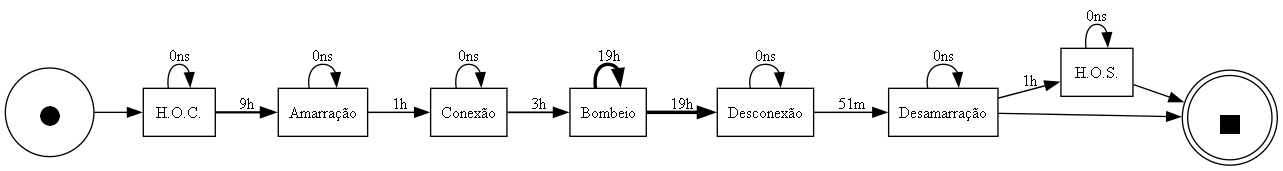

In [331]:
if __name__ == "__main__":
    #Lê o arquivo xlsx que contém o log de eventos
    log = pd.read_excel('Arquivos\\base_final.xlsx')
    if log['Início'].isnull().any():
        log = log.dropna(subset=['Início'])
    log['ID'] = log['ID'].astype(str)
    performance_dfg, start_activities, end_activities = pm4py.discover_performance_dfg(log, case_id_key='ID', activity_key='Ocorrência', timestamp_key='Início')
    pm4py.view_performance_dfg(performance_dfg, start_activities, end_activities)

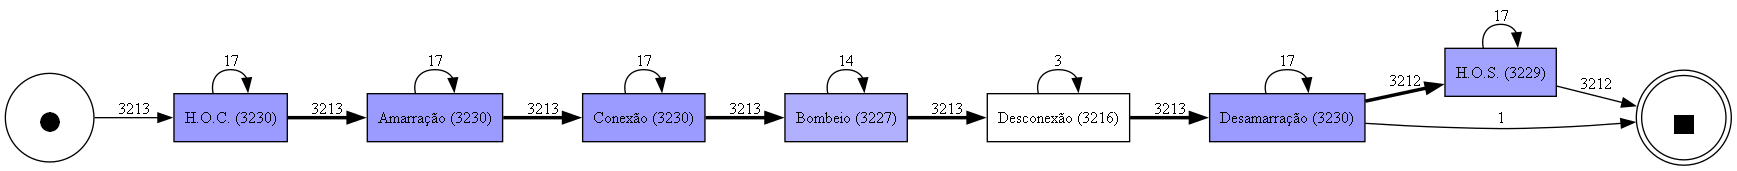

In [332]:
if __name__ == "__main__":
    log = pd.read_excel('Arquivos\\base_final.xlsx')
    if log['Início'].isnull().any():
        log = log.dropna(subset=['Início'])
    #Descobre o grafo de fluxo direcionado (DFG) e as atividades iniciais e finais.
    #O DFG mostra a relação entre as atividades no log de eventos.
    log['ID'] = log['ID'].astype(str)
    dfg, start_activities, end_activities = pm4py.discover_dfg(log,case_id_key='ID', activity_key='Ocorrência', timestamp_key='Início')
    
    #Exibe o grafo de fluxo direcionado (DFG) juntamente com as atividades iniciais e finais.
    #Isso permite visualizar a sequência de atividades no log de eventos.
    pm4py.view_dfg(dfg, start_activities, end_activities)

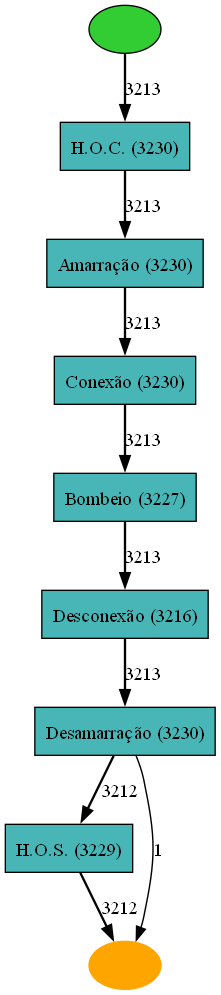

In [333]:
if __name__ == "__main__":
    # Lê o arquivo xlsx que contém o log de eventos
    log = pd.read_excel('Arquivos\\base_final.xlsx')
    if log['Início'].isnull().any():
        log = log.dropna(subset=['Início'])
    # Descobre a rede heurística a partir do log de eventos.
    # A rede heurística é uma representação gráfica de relações entre atividades comuns no log.
    log['ID'] = log['ID'].astype(str)
    heuristics_net = pm4py.discover_heuristics_net(log, case_id_key='ID',activity_key='Ocorrência', timestamp_key='Início')

    # Exibe a rede heurística.
    # Isso permite visualizar as relações entre atividades no log de eventos.
    pm4py.view_heuristics_net(heuristics_net)

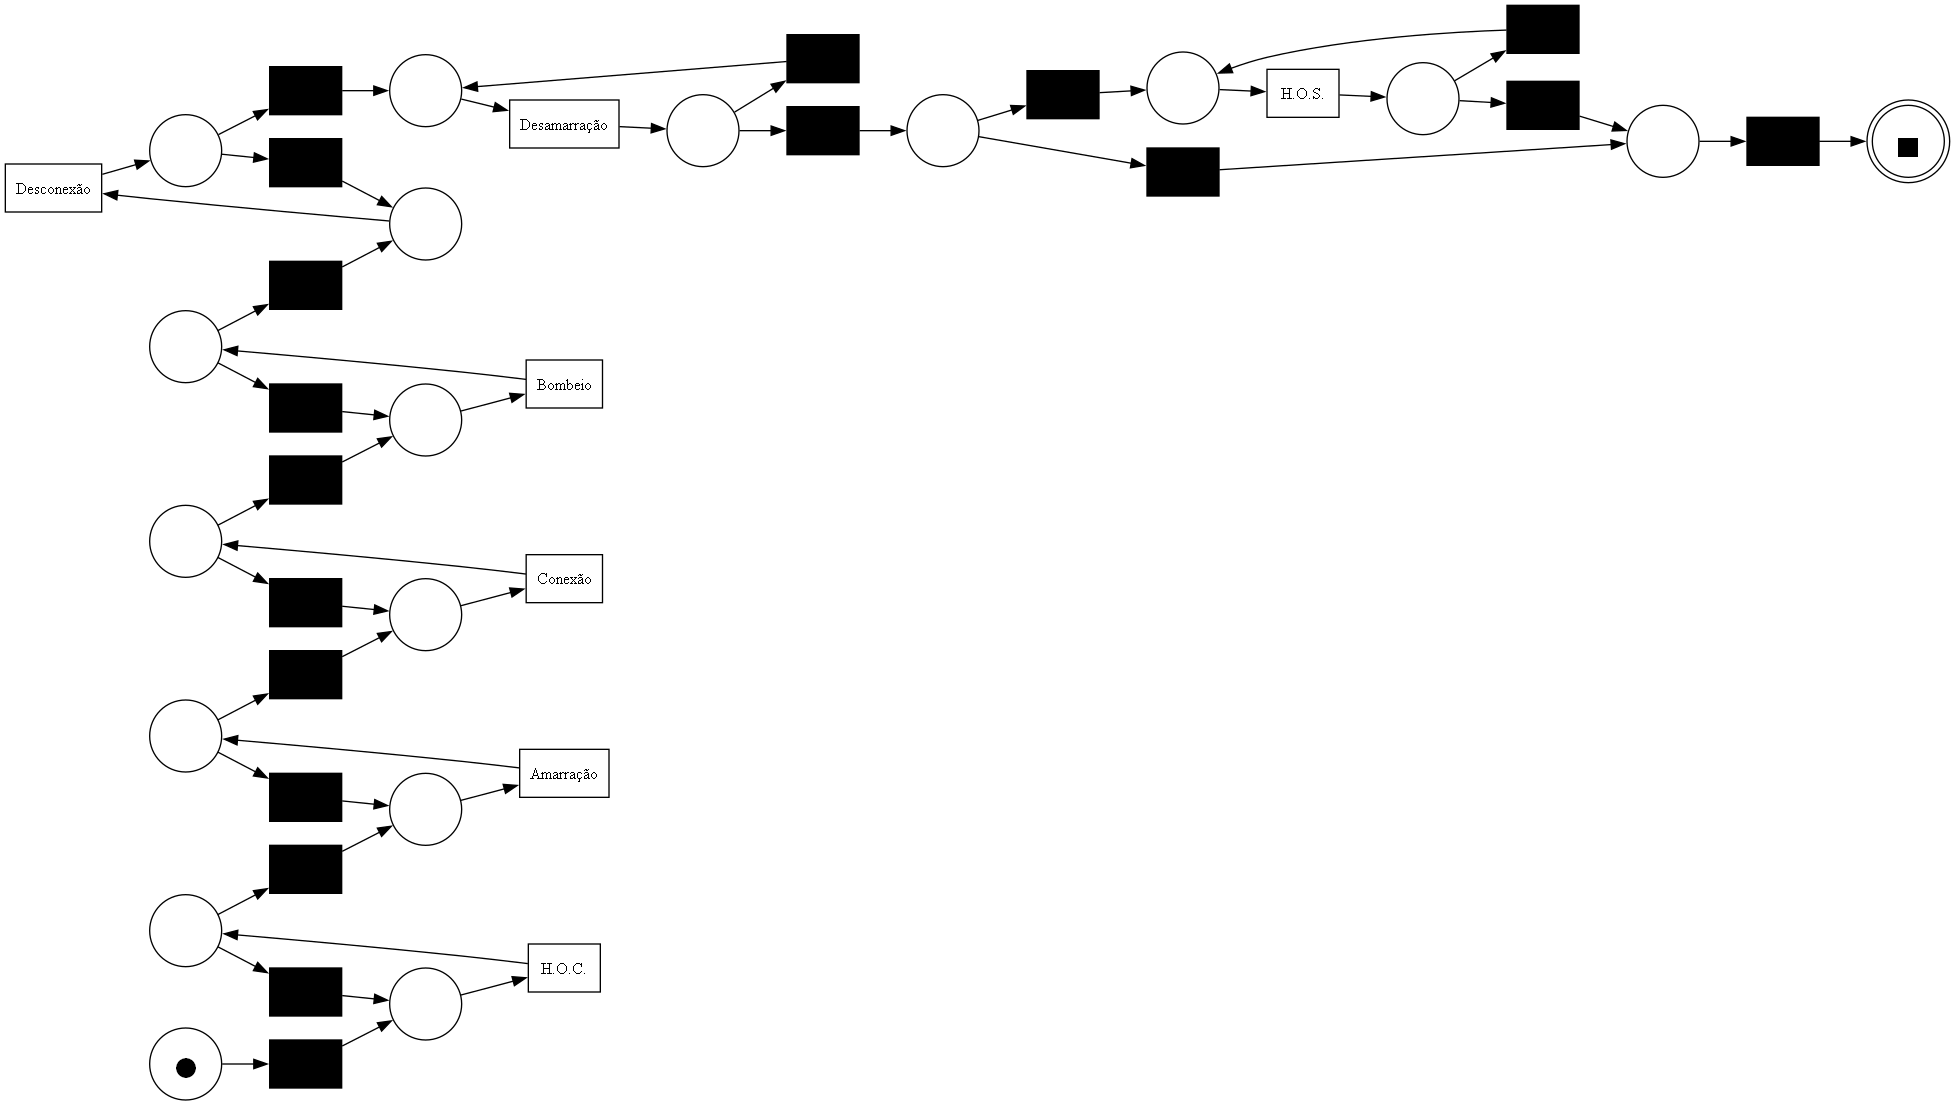

In [334]:
if __name__ == "__main__":
    #Lê o arquivo XES que contém o log de eventos.
    log = pd.read_excel('Arquivos\\base_final.xlsx')
    if log['Início'].isnull().any():
        log = log.dropna(subset=['Início'])
    #Constrói a rede de Petri a partir do log de eventos.
    #A rede de Petri é uma representação gráfica de um sistema de transição de estados.
    log['ID'] = log['ID'].astype(str)
    petri_net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log,case_id_key='ID', activity_key='Ocorrência', timestamp_key='Início')

    #Exibe a rede de Petri.
    #Isso permite visualizar a estrutura da rede de Petri construída a partir dos dados do log.
    pm4py.view_petri_net(petri_net, initial_marking, final_marking)